<a href="https://colab.research.google.com/github/Fermu25/Cursos/blob/main/Proyecto_Entregable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Identificación del número completo de la fachada de las viviendas

Se empleará el **"The Street View House Numbers (SVHN) Dataset"**

El conjunto de datos SVHN, derivado de imágenes de Google Street View, contiene más de 600,000 imágenes de dígitos

In [3]:
# Montar Drive
from google.colab import drive
drive.mount('/content/drive')

# Rutas
ZIP_PATH    = "/content/drive/MyDrive/Proyecto-TSFCII/archive.zip"
EXTRACT_DIR = "/content/svhn_zip"

import os, zipfile
os.makedirs(EXTRACT_DIR, exist_ok=True)

# Extraer base de datos
if not os.path.exists(os.path.join(EXTRACT_DIR, "archive")):
    with zipfile.ZipFile(ZIP_PATH, "r") as zf:
        zf.extractall(EXTRACT_DIR)

print("ZIP extraído en:", EXTRACT_DIR)
print("Contenido:", os.listdir(EXTRACT_DIR))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ ZIP extraído en: /content/svhn_zip
📂 Contenido: ['test', 'extra', 'test_digitStruct.mat', 'extra_digitStruct.mat', 'train', 'train_digitStruct.mat']


In [4]:
#CONFIGURACIÓN
import os, re, unicodedata
from pathlib import Path

# Raíz donde se descomprime SVHN, con estructura:
#   /content/svhn_zip/
#       ├─ train/train/*.png
#       ├─ extra/extra/*.png
#       ├─ test/test/*.png
#       ├─ train_digitStruct.mat
#       ├─ extra_digitStruct.mat
#       └─ test_digitStruct.mat

SVHN_ROOT = "/content/svhn_zip"

# Dónde se crea el dataset para entrenar YOLO
YOLO_OUT  = "/content/svhn_yolo_dataset"

# Mapa split
SPLIT_DIRS = {
    "train": f"{SVHN_ROOT}/train/train",
    "test":  f"{SVHN_ROOT}/test/test",
    "extra": f"{SVHN_ROOT}/extra/extra",
}

# Saneador robusto (quita nulls/espacios invisibles y normaliza separadores)
_WS = re.compile(r'[\s\u00A0\u2000-\u200B\u202F\u205F\u3000\uFEFF]+')
def sanitize_name(s: str) -> str:
    s = unicodedata.normalize("NFKC", s or "")
    s = s.replace("\x00", "")
    s = _WS.sub("", s)
    s = s.strip(' "\'')
    return s.replace("\\", "/")


In [8]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 70.8 MB/s eta 0:00:00


In [ ]:
# ================== LECTURA + SANITIZADO DESDE LA RAÍZ ==================
import os, csv, re, unicodedata
import h5py
import numpy as np
from pathlib import Path
from PIL import Image

# <<< AJUSTA SOLO ESTA RAÍZ >>>
SVHN_ROOT = "/content/svhn_zip"  # SIN 'archive'

# Mapear split -> carpeta REAL con imágenes (SIN 'archive')
# (tu estructura es .../extra/extra, .../train/train, .../test/test)
SPLIT_DIRS = {
    "train": f"{SVHN_ROOT}/train/train",
    "extra": f"{SVHN_ROOT}/extra/extra",
    "test":  f"{SVHN_ROOT}/test/test",
}

# -------- SANEADOR (se aplica en _read_name) --------
_WS = re.compile(r'[\s\u00A0\u2000-\u200B\u202F\u205F\u3000\uFEFF]+')  # spaces, NBSP, ZWSP, BOM…

def sanitize_name(s: str) -> str:
    """Normaliza unicode y ELIMINA todos los blancos/invisibles/NULLs y comillas sueltas."""
    s = unicodedata.normalize("NFKC", s or "")
    s = s.replace("\x00", "")
    s = _WS.sub("", s)          # <- AQUÍ quitamos blancos/invisibles
    s = s.strip(' "\'')
    s = s.replace("\\", "/")
    return s

# --------- Lectores de digitStruct.mat (con saneado al LEER) ---------
def _read_name(f, names, i):
    """Lee el nombre i-ésimo, lo DECODIFICA y lo Sanea YA aquí."""
    ref = names[i][0]
    arr = f[ref][:]
    try:
        raw = bytes(arr).decode("utf-8")
    except Exception:
        raw = "".join(chr(int(c)) for c in arr.flatten())
    return sanitize_name(raw)   # <<< SANEAR AQUÍ >>>

def _read_list(f, box, key):
    dset = box[key]
    if dset.shape[0] == 1:
        return [float(dset[0][0])]
    vals = []
    for j in range(dset.shape[0]):
        ref = dset[j][0]
        vals.append(float(f[ref][0][0]))
    return vals

def read_digit_struct_pairs(mat_path, subdir):
    """
    Devuelve [( 'split/filename.png', 'secuencia' )].
    subdir es 'train' | 'extra' | 'test' (SIN 'archive', SIN duplicar split).
    """
    pairs = []
    with h5py.File(mat_path, "r") as f:
        ds = f["digitStruct"]
        names = ds["name"]
        bboxes = ds["bbox"]
        for i in range(len(names)):
            name = _read_name(f, names, i)    # ya saneado
            box  = f[bboxes[i][0]]
            left  = np.array(_read_list(f, box, "left"))
            label = np.array(_read_list(f, box, "label"), dtype=int)
            label = np.where(label==10, 0, label)  # 10 -> 0

            order = np.argsort(left)
            seq = "".join(str(int(label[j])) for j in order)
            # <<< SOLO 'split/filename' >>>
            pairs.append((f"{subdir}/{name}", seq))
    return pairs

def read_digit_struct_boxes(mat_path, subdir):
    """
    Devuelve filas por dígito: ('split/filename', x, y, w, h, label, order)
    """
    rows = []
    with h5py.File(mat_path, "r") as f:
        ds = f["digitStruct"]
        names = ds["name"]
        bboxes = ds["bbox"]
        for i in range(len(names)):
            name = _read_name(f, names, i)    # ya saneado
            box  = f[bboxes[i][0]]

            left  = np.array(_read_list(f, box, "left"))
            top   = np.array(_read_list(f, box, "top"))
            width = np.array(_read_list(f, box, "width"))
            height= np.array(_read_list(f, box, "height"))
            label = np.array(_read_list(f, box, "label"), dtype=int)
            label = np.where(label==10, 0, label)

            order = np.argsort(left)
            for rank, j in enumerate(order, start=1):
                rows.append((
                    f"{subdir}/{name}",            # <<< SOLO 'split/filename'
                    float(left[j]), float(top[j]),
                    float(width[j]), float(height[j]),
                    int(label[j]), int(rank)
                ))
    return rows

# --------- Generación de CSVs relativos (SIN 'archive') ---------
CSV_SEQ_TRAIN = os.path.join(SVHN_ROOT, "labels_train_extra.csv")
CSV_SEQ_TEST  = os.path.join(SVHN_ROOT, "labels_test.csv")
CSV_BOX_TRAIN = os.path.join(SVHN_ROOT, "labels_train_extra_boxes.csv")
CSV_BOX_TEST  = os.path.join(SVHN_ROOT, "labels_test_boxes.csv")

# (A) Secuencias
pairs_train = []
for split in ["train", "extra"]:
    matf = os.path.join(SVHN_ROOT, f"{split}_digitStruct.mat")
    pairs_train.extend(read_digit_struct_pairs(matf, split))

with open(CSV_SEQ_TRAIN, "w", newline="") as f:
    w = csv.writer(f); w.writerow(["filename","label"])
    w.writerows(pairs_train)

pairs_test = read_digit_struct_pairs(os.path.join(SVHN_ROOT, "test_digitStruct.mat"), "test")
with open(CSV_SEQ_TEST, "w", newline="") as f:
    w = csv.writer(f); w.writerow(["filename","label"])
    w.writerows(pairs_test)

# (B) Cajas
rows_train = []
for split in ["train","extra"]:
    matf = os.path.join(SVHN_ROOT, f"{split}_digitStruct.mat")
    rows_train.extend(read_digit_struct_boxes(matf, split))

with open(CSV_BOX_TRAIN, "w", newline="") as f:
    w = csv.writer(f); w.writerow(["filename","x","y","w","h","label","order"])
    w.writerows(rows_train)

rows_test = read_digit_struct_boxes(os.path.join(SVHN_ROOT, "test_digitStruct.mat"), "test")
with open(CSV_BOX_TEST, "w", newline="") as f:
    w = csv.writer(f); w.writerow(["filename","x","y","w","h","label","order"])
    w.writerows(rows_test)

print("✅ CSVs escritos:",
      "\n  -", CSV_SEQ_TRAIN,
      "\n  -", CSV_SEQ_TEST,
      "\n  -", CSV_BOX_TRAIN,
      "\n  -", CSV_BOX_TEST)

# --------- Resolver relativo -> absoluto (usa SOLO extra/extra, sin 'archive') ---------
def resolve_path_from_csv(rel_path: str, split_dirs: dict) -> Path:
    rel_path = sanitize_name(rel_path)      # por si viniera sucio del CSV
    rel_path = rel_path.replace("\\", "/")
    parts = rel_path.split("/", 1)
    assert len(parts) == 2, f"Ruta mal formada en CSV: {rel_path}"
    split, rest = parts[0], parts[1]
    base = split_dirs[split]                # p.ej. '/content/svhn_zip/extra/extra'
    return Path(base) / rest

# --------- Chequeo rápido de 10 rutas ---------
with open(CSV_SEQ_TRAIN, "r") as f:
    rows = list(csv.reader(f))[1:]

ok = 0
for rel, _ in rows[:10]:
    p = resolve_path_from_csv(rel, SPLIT_DIRS)
    print("→", p, "exists:", p.exists())
    if p.exists():
        Image.open(p).convert("RGB")
        ok += 1
print(f"✔️ abiertas {ok}/10 sin error")

In [ ]:
# ==========================================
# 1) VISUALIZACIÓN DESDE MAT (cajas + texto)
# ==========================================
import h5py, numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def _read_name(f, names, i):
    ref = names[i][0]
    arr = f[ref][:]
    try:
        return sanitize_name(bytes(arr).decode("utf-8"))
    except Exception:
        return sanitize_name("".join(chr(int(c)) for c in arr.flatten()))

def _read_list(f, box, key):
    dset = box[key]
    if dset.shape[0] == 1:
        return [float(dset[0][0])]
    vals = []
    for j in range(dset.shape[0]):
        ref = dset[j][0]
        vals.append(float(f[ref][0][0]))
    return vals

def read_digit_struct_boxes(mat_path, split):
    """
    Devuelve filas por dígito:
      (rel_path, x, y, w, h, label, order)
    con label==10 -> 0 y 'order' izquierda→derecha.
    rel_path = 'train/XXXXX.png' | 'test/XXXXX.png' | 'extra/XXXXX.png'
    """
    rows = []
    with h5py.File(mat_path, "r") as f:
        ds = f["digitStruct"]
        names = ds["name"]
        bboxes = ds["bbox"]
        N = len(names)
        for i in range(N):
            name = _read_name(f, names, i)
            box  = f[bboxes[i][0]]

            left   = np.array(_read_list(f, box, "left"))
            top    = np.array(_read_list(f, box, "top"))
            width  = np.array(_read_list(f, box, "width"))
            height = np.array(_read_list(f, box, "height"))
            label  = np.array(_read_list(f, box, "label"), dtype=int)
            label  = np.where(label==10, 0, label)  # mapping SVHN: 10 => '0'

            order = np.argsort(left)
            rel_path = f"{split}/{name}"
            for rank, j in enumerate(order, start=1):
                rows.append((rel_path, float(left[j]), float(top[j]),
                             float(width[j]), float(height[j]),
                             int(label[j]), int(rank)))
    return rows

def resolve_abs_from_rel(rel_path: str, split_dirs: dict) -> Path:
    """'train/1.png' -> absoluto usando SPLIT_DIRS."""
    rel_path = sanitize_name(rel_path)
    parts = rel_path.split("/", 1)
    assert len(parts) == 2 and parts[0] in split_dirs, f"Ruta mal formada: {rel_path}"
    split, rest = parts
    return Path(split_dirs[split]) / rest

def show_one_example(idx, split="train"):
    assert split in ("train","test","extra")
    mat_path = os.path.join(SVHN_ROOT, f"{split}_digitStruct.mat")
    assert os.path.exists(mat_path), f"No existe: {mat_path}"

    # Leemos filas por dígito y agrupamos por imagen
    rows = read_digit_struct_boxes(mat_path, split)
    by_img = {}
    for (fn,x,y,w,h,lab,order) in rows:
        by_img.setdefault(fn, []).append((x,y,w,h,lab,order))

    files = sorted(by_img.keys())
    assert 0 <= idx < len(files), f"idx fuera de rango (0..{len(files)-1})"

    rel = files[idx]
    p = resolve_abs_from_rel(rel, SPLIT_DIRS)
    assert p.exists(), f"No existe el archivo: {p}"

    img = Image.open(p).convert("RGB")
    arr = np.array(img)

    # Ordenar por 'order' y armar secuencia
    b = sorted(by_img[rel], key=lambda t: t[5])
    seq = "".join(str(int(lab)) for (_,_,_,_,lab,_) in b)

    # Dibujar
    fig, ax = plt.subplots(1,1, figsize=(6,4))
    ax.imshow(arr)
    for (x,y,w,h,lab,ordr) in b:
        rect = patches.Rectangle((x,y), w,h, linewidth=1.5, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, max(0,y-3), f"{lab}", color='yellow', fontsize=12,
                bbox=dict(facecolor='black', alpha=0.6, pad=1))
    ax.set_title(f"{split}: {rel} — '{seq}'", fontsize=12)
    ax.axis('off')
    plt.show()
    print("🔢 Secuencia (L→R):", seq)


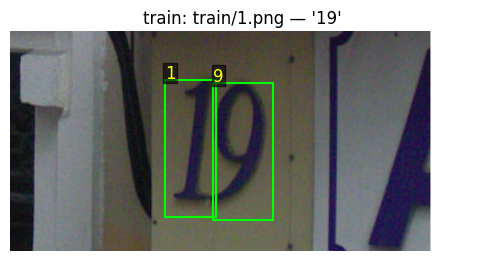

🔢 Secuencia (L→R): 19


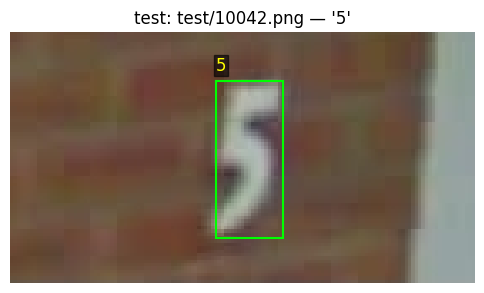

🔢 Secuencia (L→R): 5


KeyboardInterrupt: 

In [ ]:
# Unas pruebas
show_one_example(0,   "train")
show_one_example(50,  "test")
show_one_example(200, "extra")


In [ ]:
# =======================================
# 2) CONVERSIÓN SVHN → YOLO (con saneado)
# =======================================
import h5py, shutil
from PIL import Image

def asegurar_dir(p): os.makedirs(p, exist_ok=True)

def leer_digit_struct(mat_path):
    """
    Lee digitStruct.mat y devuelve una lista de anotaciones por imagen:
    [{'name': '1.png', 'labels':[...], 'left':[...], 'top':[...], 'width':[...], 'height':[...]}]
    (con 'name' ya saneado)
    """
    out = []
    with h5py.File(mat_path, 'r') as f:
        names  = f['digitStruct']['name']
        bboxes = f['digitStruct']['bbox']

        def _get_name(i):
            ref = names[i][0]
            arr = f[ref][:]
            try:    return sanitize_name(bytes(arr).decode('utf-8'))
            except: return sanitize_name(''.join(chr(int(c)) for c in arr.flatten()))

        def _get_list(bb, key):
            dset = bb[key]
            if dset.shape[0] == 1:
                return [float(dset[0][0])]
            vals = []
            for j in range(dset.shape[0]):
                ref = dset[j][0]
                vals.append(float(f[ref][0][0]))
            return vals

        for i in range(len(names)):
            name = _get_name(i)
            bb   = f[bboxes[i][0]]
            labels = [int(x) for x in _get_list(bb, 'label')]
            left   = _get_list(bb, 'left')
            top    = _get_list(bb, 'top')
            width  = _get_list(bb, 'width')
            height = _get_list(bb, 'height')
            out.append({
                'name': name, 'labels': labels,
                'left': left, 'top': top, 'width': width, 'height': height
            })
    return out

def convertir_split_svhn_a_yolo(split_svhn, split_yolo):
    """
    split_svhn: 'train' | 'extra' | 'test'
    split_yolo: 'train' | 'val'
    Crea estructura:
      YOLO_OUT/
        images/<split_yolo>/*.png
        labels/<split_yolo>/*.txt
    Cada .txt contiene líneas: class x_center y_center width height (normalizados)
    """
    print(f"→ Procesando SVHN '{split_svhn}' → YOLO '{split_yolo}'")
    dir_imgs = os.path.join(SPLIT_DIRS[split_svhn])           # p.ej. .../train/train
    mat_path = os.path.join(SVHN_ROOT, f"{split_svhn}_digitStruct.mat")
    assert os.path.isfile(mat_path), f"No existe: {mat_path}"

    ann = leer_digit_struct(mat_path)
    out_img = os.path.join(YOLO_OUT, "images", split_yolo)
    out_lbl = os.path.join(YOLO_OUT, "labels", split_yolo)
    asegurar_dir(out_img); asegurar_dir(out_lbl)

    for i, a in enumerate(ann):
        nombre_origen = a['name']                  # p.ej. "123.png"
        base = f"{split_svhn}_{nombre_origen}"     # evita colisiones entre splits
        src  = os.path.join(dir_imgs, nombre_origen)
        dst  = os.path.join(out_img, base)

        if not os.path.isfile(src):
            # Puede ocurrir algún faltante aislado; lo saltamos.
            continue

        shutil.copy2(src, dst)                     # copia imagen

        with Image.open(src) as im:
            w_img, h_img = im.size

        # Escribir etiquetas YOLO
        lbl_path = os.path.join(out_lbl, os.path.splitext(base)[0] + ".txt")
        with open(lbl_path, "w") as f:
            for lab, L, T, W, H in zip(a['labels'], a['left'], a['top'], a['width'], a['height']):
                # SVHN: 10 => dígito 0
                digit = 0 if int(lab)==10 else int(lab)
                cx = (L + W/2.0) / w_img
                cy = (T + H/2.0) / h_img
                wn = W / w_img
                hn = H / h_img
                f.write(f"{digit} {cx:.6f} {cy:.6f} {wn:.6f} {hn:.6f}\n")

        if (i+1) % 5000 == 0:
            print(f"  {i+1}/{len(ann)} imágenes...")

    print(f"✔ Split '{split_svhn}' → '{split_yolo}' listo. Imágenes: {len(ann)}")

def escribir_yaml_ultralytics():
    """Genera svhn_yolo.yaml para entrenar con Ultralytics YOLO."""
    yaml_path = os.path.join(YOLO_OUT, "svhn_yolo.yaml")
    content = f"""# Dataset SVHN en formato YOLO
path: {YOLO_OUT}
train: images/train
val: images/val
nc: 10
names: ["0","1","2","3","4","5","6","7","8","9"]
"""
    with open(yaml_path, "w") as f:
        f.write(content)
    print("✔ YAML escrito en:", yaml_path)

# Ejecutar conversión (train+extra → train, test → val)
os.makedirs(os.path.join(YOLO_OUT, "images", "train"), exist_ok=True)
os.makedirs(os.path.join(YOLO_OUT, "images", "val"),   exist_ok=True)
os.makedirs(os.path.join(YOLO_OUT, "labels", "train"), exist_ok=True)
os.makedirs(os.path.join(YOLO_OUT, "labels", "val"),   exist_ok=True)

for split in ["train", "extra"]:
    convertir_split_svhn_a_yolo(split, "train")

convertir_split_svhn_a_yolo("test", "val")
escribir_yaml_ultralytics()


→ Procesando SVHN 'train' → YOLO 'train'
  5000/33402 imágenes...
  10000/33402 imágenes...
  15000/33402 imágenes...
  20000/33402 imágenes...
  25000/33402 imágenes...
  30000/33402 imágenes...
✔ Split 'train' → 'train' listo. Imágenes: 33402
→ Procesando SVHN 'extra' → YOLO 'train'
  5000/202353 imágenes...
  10000/202353 imágenes...
  15000/202353 imágenes...
  20000/202353 imágenes...
  25000/202353 imágenes...
  30000/202353 imágenes...
  35000/202353 imágenes...
  40000/202353 imágenes...
  45000/202353 imágenes...
  50000/202353 imágenes...
  55000/202353 imágenes...
  60000/202353 imágenes...
  65000/202353 imágenes...
  70000/202353 imágenes...
  75000/202353 imágenes...
  80000/202353 imágenes...
  85000/202353 imágenes...
  90000/202353 imágenes...
  95000/202353 imágenes...
  100000/202353 imágenes...
  105000/202353 imágenes...
  110000/202353 imágenes...
  115000/202353 imágenes...
  120000/202353 imágenes...
  125000/202353 imágenes...
  130000/202353 imágenes...
  1350

In [ ]:
# ==============================================
# 3) VERIFICACIÓN RÁPIDA (MAT vs TXT de YOLO)
# ==============================================
import random

def verificar_un_ejemplo_yolo(split_svhn="test"):
    """
    Toma una imagen aleatoria del split y verifica que su .txt YOLO
    coincide (aprox) con las cajas del .mat.
    """
    dir_imgs = SPLIT_DIRS[split_svhn]
    mat_path = os.path.join(SVHN_ROOT, f"{split_svhn}_digitStruct.mat")
    ann = leer_digit_struct(mat_path)
    a = random.choice(ann)

    base = f"{split_svhn}_{a['name']}"
    sub = "val" if split_svhn=="test" else "train"
    yolo_txt = os.path.join(YOLO_OUT, "labels", sub, os.path.splitext(base)[0] + ".txt")
    img_path = os.path.join(dir_imgs, a['name'])

    assert os.path.exists(yolo_txt), f"Falta etiqueta YOLO: {yolo_txt}"
    assert os.path.exists(img_path), f"Falta imagen: {img_path}"

    from PIL import Image
    w_img, h_img = Image.open(img_path).size

    with open(yolo_txt, "r") as f:
        yolo_lines = [l.strip() for l in f.readlines() if l.strip()]

    ok = True
    for i, (lab, L, T, W, H) in enumerate(zip(a['labels'], a['left'], a['top'], a['width'], a['height'])):
        digit = 0 if int(lab)==10 else int(lab)
        cx = (L + W/2.0) / w_img
        cy = (T + H/2.0) / h_img
        wn = W / w_img
        hn = H / h_img

        # Buscamos ANY línea compatible dentro de una tolerancia por redondeos
        match = any(
            line.startswith(f"{digit} ") and
            all(abs(float(tok) - val) < 1e-2 for tok, val in zip(line.split()[1:], [cx, cy, wn, hn]))
            for line in yolo_lines
        )
        if not match:
            ok = False
            print("❌ Desajuste en bbox", i, "| esperado:",
                  f"class={digit}, cx={cx:.4f}, cy={cy:.4f}, w={wn:.4f}, h={hn:.4f}")

    print("✅ Verificación YOLO vs MAT:", "OK" if ok else "HAY DIFERENCIAS")

# USO:
verificar_un_ejemplo_yolo("test")   # o "train"/"extra"


✅ Verificación YOLO vs MAT: OK


In [10]:
# ============================================================
# YOLOv8: (opcional) convertir SVHN → dataset YOLO + entrenamiento
# ============================================================
import os, re, unicodedata
import numpy as np
from PIL import Image
import h5py

# ----------------- CONFIG -----------------
RAIZ_SVHN   = "/content/svhn_zip"               # raíz REAL (sin 'archive')
SALIDA_YOLO = "/content/svhn_yolo_dataset"      # carpeta del dataset YOLO
DATA_YAML   = os.path.join(SALIDA_YOLO, "svhn_yolo.yaml")

# Si YA convertiste a YOLO, pon esto en False para saltar conversión
RUN_CONVERSION = True   # <----- cambia a True SOLO si aún no tienes el dataset YOLO

# Entrenamiento YOLOv8
PESOS_BASE   = "yolov8n.pt"     # puedes cambiar a yolov8s.pt, etc.
EPOCAS       = 50 #subir a 100 epocas, 50 no son suficientes, pero bastan por ahora
IMG_SIZE     = 128
BATCH        = 64
NOMBRE_RUN   = "svhn_yolov8n"

# ----------------- SANEADOR -----------------
_WS = re.compile(r'[\s\u00A0\u2000-\u200B\u202F\u205F\u3000\uFEFF]+')
def sanitize_name(s: str) -> str:
    s = unicodedata.normalize("NFKC", s or "")
    s = s.replace("\x00", "")
    s = _WS.sub("", s)
    s = s.strip(' "\'')
    return s.replace("\\", "/")

# ----------------- LECTOR digitStruct.mat -----------------
def leer_digit_struct(mat_path):
    out = []
    with h5py.File(mat_path, 'r') as f:
        names  = f['digitStruct']['name']
        bboxes = f['digitStruct']['bbox']

        def _get_name(i):
            ref = names[i][0]
            arr = f[ref][:]
            try:
                return sanitize_name(bytes(arr).decode('utf-8'))
            except:
                return sanitize_name(''.join(chr(int(c)) for c in arr.flatten()))

        def _get_list(bb, key):
            dset = bb[key]
            if dset.shape[0] == 1:
                return [float(dset[0][0])]
            vals = []
            for j in range(dset.shape[0]):
                ref = dset[j][0]
                vals.append(float(f[ref][0][0]))
            return vals

        for i in range(len(names)):
            name = _get_name(i)
            bb   = f[bboxes[i][0]]
            labels = [int(x) for x in _get_list(bb, 'label')]
            left   = _get_list(bb, 'left')
            top    = _get_list(bb, 'top')
            width  = _get_list(bb, 'width')
            height = _get_list(bb, 'height')
            out.append({
                'name': name, 'labels': labels,
                'left': left, 'top': top, 'width': width, 'height': height
            })
    return out

# ----------------- CONVERSIÓN → YOLO -----------------
def asegurar_dir(p): os.makedirs(p, exist_ok=True)

def convertir_split_svhn_a_yolo(split_svhn, split_yolo):
    """
    Crea:
      SALIDA_YOLO/images/<split_yolo>/*.png
      SALIDA_YOLO/labels/<split_yolo>/*.txt
    """
    print(f"→ Procesando SVHN '{split_svhn}' → YOLO '{split_yolo}'")
    dir_imgs = os.path.join(RAIZ_SVHN, split_svhn, split_svhn)  # p.ej. .../train/train
    mat_path = os.path.join(RAIZ_SVHN, f"{split_svhn}_digitStruct.mat")
    assert os.path.isfile(mat_path), f"No existe: {mat_path}"
    ann = leer_digit_struct(mat_path)

    out_img = os.path.join(SALIDA_YOLO, "images", split_yolo)
    out_lbl = os.path.join(SALIDA_YOLO, "labels", split_yolo)
    asegurar_dir(out_img); asegurar_dir(out_lbl)

    for i, a in enumerate(ann):
        base = f"{split_svhn}_{a['name']}"           # prefijo para evitar colisiones
        src  = os.path.join(dir_imgs, a['name'])
        dst  = os.path.join(out_img, base)
        if not os.path.isfile(src):
            continue
        # copiar/guardar imagen
        Image.open(src).save(dst)

        w_img, h_img = Image.open(src).size
        # escribir .txt YOLO
        lbl_path = os.path.join(out_lbl, os.path.splitext(base)[0] + ".txt")
        with open(lbl_path, "w") as f:
            for lab, L, T, W, H in zip(a['labels'], a['left'], a['top'], a['width'], a['height']):
                digit = 0 if int(lab)==10 else int(lab)  # SVHN: 10 -> 0
                cx = (L + W/2.0) / w_img
                cy = (T + H/2.0) / h_img
                wn = W / w_img
                hn = H / h_img
                f.write(f"{digit} {cx:.6f} {cy:.6f} {wn:.6f} {hn:.6f}\n")

        if (i+1) % 5000 == 0:
            print(f"  {i+1}/{len(ann)} imágenes...")

    print(f"✔ Split '{split_svhn}' → '{split_yolo}' listo. Imágenes: {len(ann)}")

def escribir_yaml_ultralytics():
    content = f"""# Dataset SVHN en formato YOLO (Ultralytics)
path: {SALIDA_YOLO}
train: images/train
val: images/val
nc: 10
names: ["0","1","2","3","4","5","6","7","8","9"]
"""
    yaml_path = os.path.join(SALIDA_YOLO, "svhn_yolo.yaml")
    with open(yaml_path, "w") as f: f.write(content)
    print("✔ YAML:", yaml_path)

# Ejecutar conversión solo si la pediste o si falta la estructura
if RUN_CONVERSION or not os.path.exists(DATA_YAML):
    os.makedirs(os.path.join(SALIDA_YOLO, "images", "train"), exist_ok=True)
    os.makedirs(os.path.join(SALIDA_YOLO, "images", "val"),   exist_ok=True)
    os.makedirs(os.path.join(SALIDA_YOLO, "labels", "train"), exist_ok=True)
    os.makedirs(os.path.join(SALIDA_YOLO, "labels", "val"),   exist_ok=True)

    for s in ["train","extra"]: convertir_split_svhn_a_yolo(s, "train")
    for s in ["test"]:          convertir_split_svhn_a_yolo(s, "val")
    escribir_yaml_ultralytics()
else:
    print("✔ Dataset YOLO ya existe. Omitiendo conversión.")

# ----------------- ENTRENAR YOLOv8 -----------------
try:
    from ultralytics import YOLO
    modelo_yolo = YOLO(PESOS_BASE)
    modelo_yolo.train(
        data=DATA_YAML,
        epochs=EPOCAS,
        imgsz=IMG_SIZE,
        batch=BATCH,
        name=NOMBRE_RUN,
        project=os.path.join(SALIDA_YOLO, "runs")
    )
    # Validación
    modelo_yolo.val(data=DATA_YAML, imgsz=IMG_SIZE, batch=BATCH)
    print("✅ Entrenamiento YOLOv8 finalizado.")
except Exception as e:
    print("ℹ️ No se pudo entrenar YOLOv8 (¿falta 'ultralytics'?). Detalle:", e)


→ Procesando SVHN 'train' → YOLO 'train'
  5000/33402 imágenes...
  10000/33402 imágenes...
  15000/33402 imágenes...
  20000/33402 imágenes...
  25000/33402 imágenes...
  30000/33402 imágenes...
✔ Split 'train' → 'train' listo. Imágenes: 33402
→ Procesando SVHN 'extra' → YOLO 'train'
  5000/202353 imágenes...
  10000/202353 imágenes...
  15000/202353 imágenes...
  20000/202353 imágenes...
  25000/202353 imágenes...
  30000/202353 imágenes...
  35000/202353 imágenes...
  40000/202353 imágenes...
  45000/202353 imágenes...
  50000/202353 imágenes...
  55000/202353 imágenes...
  60000/202353 imágenes...
  65000/202353 imágenes...
  70000/202353 imágenes...
  75000/202353 imágenes...
  80000/202353 imágenes...
  85000/202353 imágenes...
  90000/202353 imágenes...
  95000/202353 imágenes...
  100000/202353 imágenes...
  105000/202353 imágenes...
  110000/202353 imágenes...
  115000/202353 imágenes...
  120000/202353 imágenes...
  125000/202353 imágenes...
  130000/202353 imágenes...
  1350

In [9]:
# ==================================================================================
# MAESTRO SVHN YOLOv8: Pipeline Completo & Optimizado (Colab T4 High-RAM)
# ==================================================================================
import os, re, unicodedata
import numpy as np
from PIL import Image
import h5py
import torch
import shutil

# --- 0. VERIFICACIÓN DE ENTORNO ---
print("🔍 Verificando hardware...")
if torch.cuda.is_available():
    vram = torch.cuda.get_device_properties(0).total_memory / 1e9
    torch.cuda.empty_cache()
    print(f"   🔥 GPU Detectada: {torch.cuda.get_device_name(0)}")
    print(f"   🧠 VRAM Disponible: {vram:.1f} GB (Ideal para AutoBatch)")
else:
    print("   ❌ NO SE DETECTA GPU. El entrenamiento será eterno. Activa GPU en Colab.")

# ----------------- CONFIGURACIÓN GLOBAL -----------------
# Rutas
RAIZ_SVHN   = "/content/svhn_zip"              # Carpeta donde descomprimiste SVHN
SALIDA_YOLO = "/content/svhn_yolo_dataset"     # Carpeta destino para YOLO
DATA_YAML   = os.path.join(SALIDA_YOLO, "svhn_yolo.yaml")
SEED        = 42

# Flags
RUN_CONVERSION = False   # Pon True si necesitas forzar la re-conversión de datos

# Hiperparámetros de Entrenamiento (Estrategia T4 High-RAM)
PESOS_BASE  = "yolov8s.pt"       # Modelo 'Small': Mejor que Nano para OCR, cabe en T4
NOMBRE_RUN  = "svhn_yolov8s_640_pro"
EPOCAS      = 100                # 100 es el estándar para convergencia sólida
IMG_SIZE    = 640                # 640px: Resolución estándar (mejor recall que 320px)
BATCH       = -1                 # AUTOBATCH: YOLO llenará la VRAM (aprox 32-64 imgs)
PATIENCE    = 15                 # Early Stopping

# ----------------- 1. UTILIDADES DE LIMPIEZA -----------------
_WS = re.compile(r'[\s\u00A0\u2000-\u200B\u202F\u205F\u3000\uFEFF]+')
def sanitize_name(s: str) -> str:
    s = unicodedata.normalize("NFKC", s or "")
    s = s.replace("\x00", "")
    s = _WS.sub("", s)
    s = s.strip(' "\'')
    return s.replace("\\", "/")

def asegurar_dir(p): os.makedirs(p, exist_ok=True)

# ----------------- 2. LECTURA DE MATADATOS (MATLAB) -----------------
def leer_digit_struct(mat_path):
    out = []
    if not os.path.exists(mat_path):
        print(f"   ⚠️ Archivo no encontrado: {mat_path}")
        return []

    print(f"   📂 Leyendo estructura: {os.path.basename(mat_path)} ...")
    with h5py.File(mat_path, 'r') as f:
        names  = f['digitStruct']['name']
        bboxes = f['digitStruct']['bbox']

        # Helpers internos para leer h5py referencias
        def _get_name(i):
            ref = names[i][0]
            arr = f[ref][:]
            try: return sanitize_name(bytes(arr).decode('utf-8'))
            except: return sanitize_name(''.join(chr(int(c)) for c in arr.flatten()))

        def _get_list(bb, key):
            dset = bb[key]
            if dset.shape[0] == 1: return [float(dset[0][0])]
            vals = []
            for j in range(dset.shape[0]):
                ref = dset[j][0]
                vals.append(float(f[ref][0][0]))
            return vals

        total = len(names)
        for i in range(total):
            name = _get_name(i)
            bb   = f[bboxes[i][0]]
            out.append({
                'name': name,
                'labels': [int(x) for x in _get_list(bb, 'label')],
                'left':   _get_list(bb, 'left'),
                'top':    _get_list(bb, 'top'),
                'width':  _get_list(bb, 'width'),
                'height': _get_list(bb, 'height')
            })
            if (i+1) % 50000 == 0:
                print(f"      Procesados {i+1}/{total} registros...")
    return out

# ----------------- 3. CONVERSIÓN A YOLO -----------------
def convertir_split(split_svhn, split_yolo):
    print(f"→ Procesando Split: '{split_svhn}' hacia '{split_yolo}'...")
    dir_imgs = os.path.join(RAIZ_SVHN, split_svhn, split_svhn)
    mat_path = os.path.join(RAIZ_SVHN, f"{split_svhn}_digitStruct.mat")

    ann = leer_digit_struct(mat_path)
    if not ann: return

    out_img = os.path.join(SALIDA_YOLO, "images", split_yolo)
    out_lbl = os.path.join(SALIDA_YOLO, "labels", split_yolo)
    asegurar_dir(out_img); asegurar_dir(out_lbl)

    count = 0
    for a in ann:
        base = f"{split_svhn}_{a['name']}" # Prefijo único
        src  = os.path.join(dir_imgs, a['name'])
        dst  = os.path.join(out_img, base)

        if not os.path.isfile(src): continue

        try:
            with Image.open(src) as im:
                im.save(dst)
                w_img, h_img = im.size
        except: continue # Imagen corrupta, saltar

        # Generar .txt YOLO
        txt_path = os.path.join(out_lbl, os.path.splitext(base)[0] + ".txt")
        with open(txt_path, "w") as f:
            for lab, L, T, W, H in zip(a['labels'], a['left'], a['top'], a['width'], a['height']):
                # SVHN: 10=0, 1=1...
                digit = 0 if int(lab) == 10 else int(lab)

                # Normalizar xywh (0-1)
                cx = (L + W/2.0) / w_img
                cy = (T + H/2.0) / h_img
                wn = W / w_img
                hn = H / h_img

                # Clipping de seguridad
                cx = max(0, min(1, cx)); cy = max(0, min(1, cy))
                wn = max(0, min(1, wn)); hn = max(0, min(1, hn))

                f.write(f"{digit} {cx:.6f} {cy:.6f} {wn:.6f} {hn:.6f}\n")

        count += 1
        if count % 10000 == 0: print(f"   Imágenes generadas: {count}...")

    print(f"✔ Fin {split_svhn}. Total válidas: {count}")

def crear_yaml():
    contenido = f"""
path: {SALIDA_YOLO}
train: images/train
val: images/val
nc: 10
names: ["0","1","2","3","4","5","6","7","8","9"]
"""
    with open(DATA_YAML, "w") as f: f.write(contenido)
    print(f"✔ YAML Config creado en: {DATA_YAML}")

# --- Ejecución Conversión ---
if RUN_CONVERSION or not os.path.exists(DATA_YAML):
    print("\n⚙️  INICIANDO CONVERSIÓN DE DATASET...")
    # Limpiar si existe para evitar duplicados
    if os.path.exists(SALIDA_YOLO): shutil.rmtree(SALIDA_YOLO)

    convertir_split("train", "train")
    convertir_split("extra", "train") # 'extra' va al train para mejor precisión
    convertir_split("test",  "val")
    crear_yaml()
else:
    print("\n✅ Dataset YOLO detectado. Saltando conversión.")


# ----------------- 4. ENTRENAMIENTO (OPTIMIZADO) -----------------
print(f"\n🚀 INICIANDO ENTRENAMIENTO YOLOv8")
print(f"   📋 Config: {PESOS_BASE} | 🖼️ Size: {IMG_SIZE} | ⚡ RAM Cache: ACTIVADO")

try:
    from ultralytics import YOLO

    # Cargar pesos pre-entrenados
    model = YOLO(PESOS_BASE)

    # Entrenar
    model.train(
        data=DATA_YAML,
        project=os.path.join(SALIDA_YOLO, "runs"),
        name=NOMBRE_RUN,

        # --- HARDWARE (T4 + 50GB RAM) ---
        epochs=EPOCAS,
        imgsz=IMG_SIZE,     # 640px para ver números pequeños
        batch=BATCH,        # -1 = AutoBatch (Máxima VRAM posible)
        cache=True,         # USA TUS 50GB DE RAM PARA ACELERAR EL ENTRENAMIENTO
        workers=8,          # CPU workers

        # --- GENERAL ---
        patience=PATIENCE,
        seed=SEED,
        exist_ok=True,      # Sobreescribir carpeta run si existe
        save_period=10,     # Guardar pesos cada 10 epocas
        plots=True,         # Guardar curvas de loss/map

        # --- DATA AUGMENTATION (OCR MODE) ---
        # Configuración específica para NO romper números
        degrees=10.0,       # Rotación ligera (+/- 10°)
        translate=0.1,      # Mover imagen 10%
        scale=0.5,          # Escalar +/- 50% (Vital para números de distinto tamaño)
        shear=0.0,          # Deformar: NO
        perspective=0.0,    # Perspectiva: NO

        flipud=0.0,         # ⛔ ESPEJO VERTICAL APAGADO (evita 6 <-> 9)
        fliplr=0.0,         # ⛔ ESPEJO HORIZONTAL APAGADO (evita 3 <-> E)

        mosaic=1.0,         # Mosaic ayuda a detectar objetos juntos
        mixup=0.0,          # Mixup apagado (confunde OCR)
        close_mosaic=10     # Apagar mosaic al final para precisión fina
    )

    # Validación Final
    print("\n🏁 Entrenamiento finalizado. Validando mejor modelo...")
    metrics = model.val(data=DATA_YAML, imgsz=IMG_SIZE, batch=BATCH)

    ruta_best = os.path.join(SALIDA_YOLO, "runs", NOMBRE_RUN, "weights", "best.pt")
    print(f"\n🏆 MEJOR MODELO GUARDADO EN:\n   {ruta_best}")
    print("   (Usa este archivo .pt para tus predicciones)")

except ImportError:
    print("❌ Error: Librería 'ultralytics' no instalada.")
    print("   Ejecuta: !pip install ultralytics")
except Exception as e:
    print(f"❌ Error crítico en entrenamiento: {e}")


🔍 Verificando hardware...
   🔥 GPU Detectada: NVIDIA A100-SXM4-80GB
   🧠 VRAM Disponible: 85.2 GB (Ideal para AutoBatch)

✅ Dataset YOLO detectado. Saltando conversión.

🚀 INICIANDO ENTRENAMIENTO YOLOv8
   📋 Config: yolov8s.pt | 🖼️ Size: 640 | ⚡ RAM Cache: ACTIVADO
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/svhn_yolo_dataset/svhn_yolo.yaml, degrees=10.0

KeyboardInterrupt: 

🔥 A100 Detectada. Usando política: bfloat16
Train: 223968 | Val: 11787 | Test: 13068



Model: "CRNN_A100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 32, 128, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 32, 128, 64)    │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_84          │ (None, 32, 128, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_84 (ReLU)                 │ (None, 32, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 16, 64, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_85          │ (None, 16, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_85 (ReLU)                 │ (None, 16, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_24            │ (None, 8, 32, 128)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 8, 32, 256)     │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_86          │ (None, 8, 32, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_86 (ReLU)                 │ (None, 8, 32, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 8, 32, 256)     │       589,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_87          │ (None, 8, 32, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_87 (ReLU)                 │ (None, 8, 32, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 4, 32, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_25            │ (None, 4, 32, 256)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 4, 32, 512)     │     1,179,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_88          │ (None, 4, 32, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_88 (ReLU)                 │ (None, 4, 32, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,712,139 (33.23 MB)

 Trainable params: 8,707,659 (33.22 MB)

 Non-trainable params: 4,480 (17.50 KB)


🔧 Configuración de Rescate: LR=0.0001 | Global Clip=5.0
🧹 Limpiando memoria y reconstruyendo modelo...
🚀 INTENTO 3: START (Si ves loss > 100 es normal, bajará rápido)
Epoch 1/5 | loss: 4.1071 | val_loss: 1.2973 | CER: 0.8385
   ⭐ Guardado!
Epoch 2/5 | loss: 1.1348 | val_loss: 0.9111 | CER: 0.8397
   ⏳ Wait 1/5
Epoch 3/5 | loss: 0.8253 | val_loss: 0.7492 | CER: 0.8450
   ⏳ Wait 2/5
Epoch 4/5 | loss: 0.6787 | val_loss: 0.6657 | CER: 0.8304
   ⭐ Guardado!
Epoch 5/5 | loss: 0.5881 | val_loss: 0.6380 | CER: 0.8848
   ⏳ Wait 1/5
⏱️ Tiempo total: 22.5 min

📊 Generando gráficos...


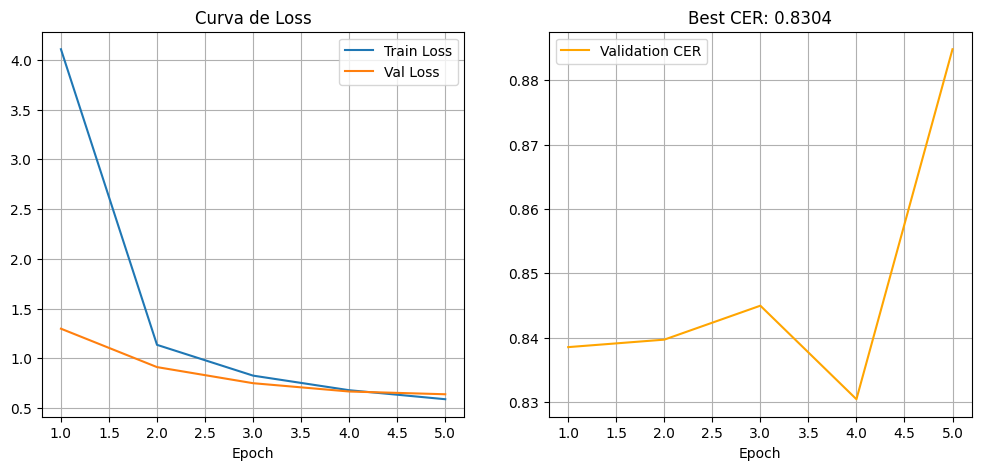


🔍 EVALUANDO MODELO EN TEST SET (Imágenes nunca vistas)
Procesando Test Set...

🏆 RESULTADOS FINALES TEST SET:
   ➤ Accuracy (Exact Match): 0.00%
   ➤ CER (Error Letras):     0.9799

📸 Generando imagen de muestra...


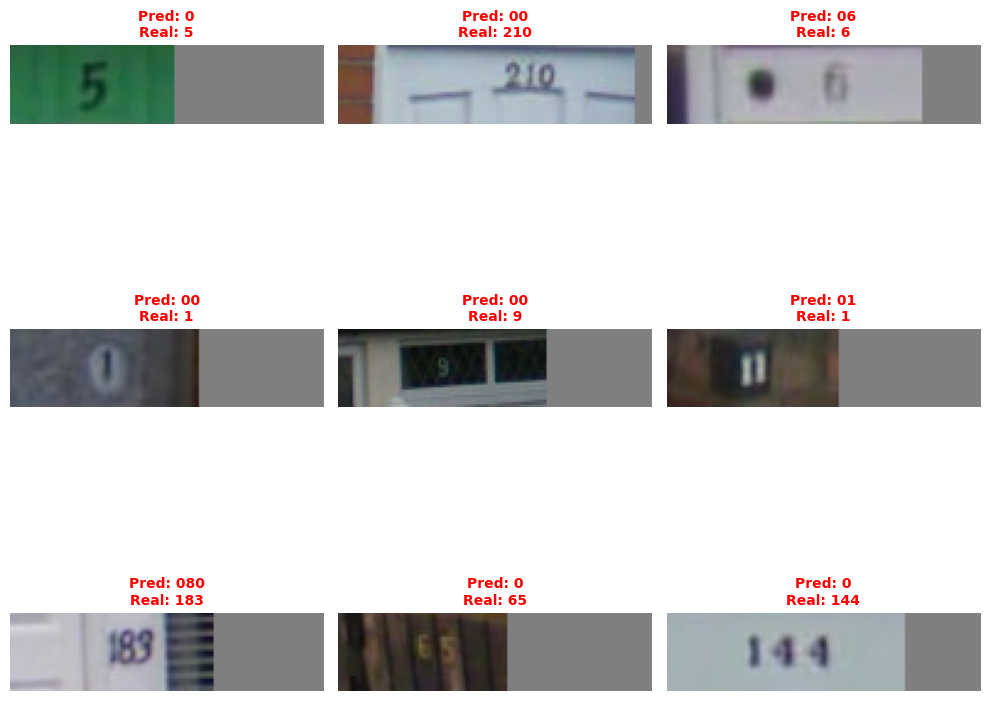


💾 Guardando modelo portable...
✅ Todo listo. Resultados en: /content/svhn_zip/resultados_finales


In [21]:
# CRNN

#INSTALACIÓN DE DEPENDENCIAS
import os
os.system('pip install python-Levenshtein')

import csv, re, unicodedata, random, time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Levenshtein

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, mixed_precision

# ----------------- CONFIGURACIÓN HARDWARE -----------------
try:
    # Usamos bfloat16 (Nativo A100, no requiere Loss Scaling)
    policy = mixed_precision.Policy('mixed_bfloat16')
    mixed_precision.set_global_policy(policy)
    print(f"Usando política: {policy.compute_dtype}")
except:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print(" Usando float16 estándar.")

#Configuración
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

RAIZ_SVHN = "/content/svhn_zip"
CSV_TRAIN = os.path.join(RAIZ_SVHN, "labels_train_extra.csv")
CSV_TEST  = os.path.join(RAIZ_SVHN, "labels_test.csv")

SPLIT_DIRS = {
    "train": f"{RAIZ_SVHN}/train/train",
    "extra": f"{RAIZ_SVHN}/extra/extra",
    "test":  f"{RAIZ_SVHN}/test/test",
}

IMG_H, IMG_W = 32, 128
BATCH_SIZE   = 256        # Batch masivo para la A100
EPOCHS       = 50
LR_INICIAL   = 1e-3
PATIENCE     = 5
MIN_DELTA    = 1e-4

ALFABETO      = "0123456789"
INDICE_BLANCO = len(ALFABETO)
NUM_CLASES    = len(ALFABETO) + 1
CRNN_MEJOR_WEIGHTS = os.path.join(RAIZ_SVHN, "crnn_a100_best.weights.h5")
DIR_SALIDA = os.path.join(RAIZ_SVHN, "resultados_finales")

# ----------------- 4. UTILIDADES DE CARGA -----------------
_WS = re.compile(r'[\s\u00A0\u2000-\u200B\u202F\u205F\u3000\uFEFF]+')
def sanear(s: str) -> str:
    s = unicodedata.normalize("NFKC", s or "")
    s = s.replace("\x00", "").strip(' "\'')
    return _WS.sub("", s).replace("\\", "/")

def resolver_abs_desde_rel(rel_path: str) -> Path:
    rel_path = sanear(rel_path)
    parts = rel_path.split("/", 1)
    if len(parts) == 2 and parts[0] in SPLIT_DIRS:
        return Path(SPLIT_DIRS[parts[0]]) / parts[1]
    return Path(rel_path)

def cargar_pairs_csv(csv_file: str):
    if not os.path.exists(csv_file): return []
    with open(csv_file, "r") as f:
        rdr = list(csv.reader(f))
    start = 1 if (len(rdr)>0 and "filename" in rdr[0][0].lower()) else 0
    crudos = [(sanear(r[0]), sanear(r[1])) for r in rdr[start:] if len(r)>=2]

    out = []
    for rel, lab in crudos:
        try: p = resolver_abs_desde_rel(rel)
        except: continue
        if p.exists(): out.append((str(p), lab))
    return out

# Carga
pairs_all  = cargar_pairs_csv(CSV_TRAIN)
pairs_test = cargar_pairs_csv(CSV_TEST)

idxs = np.arange(len(pairs_all)); np.random.RandomState(SEED).shuffle(idxs)
val_n = int(0.05 * len(pairs_all))
val_idx, tr_idx = idxs[:val_n], idxs[val_n:]
pairs_train = [pairs_all[i] for i in tr_idx]
pairs_val   = [pairs_all[i] for i in val_idx]

print(f"Train: {len(pairs_train)} | Val: {len(pairs_val)} | Test: {len(pairs_test)}")

# ----------------- 5. PIPELINE TF.DATA -----------------
def str_a_ints(s): return [ord(c)-ord('0') for c in s]

def preprocess_raw(path):
    data = tf.io.read_file(path)
    img  = tf.image.decode_png(data, channels=3)
    img  = tf.image.convert_image_dtype(img, tf.float32)
    h = tf.cast(tf.shape(img)[0], tf.float32)
    w = tf.cast(tf.shape(img)[1], tf.float32)
    new_w = tf.cast(tf.math.maximum(1.0, tf.math.round(w * (IMG_H / h))), tf.int32)
    img_res = tf.image.resize(img, size=(IMG_H, new_w))

    if_pad = tf.less(new_w, IMG_W)
    def _pad():
        pad_w = IMG_W - new_w
        return tf.pad(img_res, [[0,0],[0,pad_w],[0,0]], constant_values=0.5)
    def _crop():
        return tf.image.crop_to_bounding_box(img_res, 0, 0, IMG_H, IMG_W)

    img_fixed = tf.cond(if_pad, _pad, _crop)
    return (img_fixed - 0.5) / 0.5

@tf.function
def augment_img(img, lab, ln):
    img = tf.image.random_brightness(img, 0.2)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.clip_by_value(img, -1.0, 1.0)
    return img, lab, ln

def make_dataset(pairs_list, is_training):
    paths = [p for p,_ in pairs_list]
    labs  = [str_a_ints(l) for _,l in pairs_list]
    lens  = [len(v) for v in labs]
    max_len = max(lens) if lens else 1
    labs_padded = [np.pad(np.array(v, dtype=np.int32), (0, max_len-len(v)), constant_values=-1) for v in labs]

    ds_img = tf.data.Dataset.from_tensor_slices(paths).map(preprocess_raw, num_parallel_calls=tf.data.AUTOTUNE)
    ds_lab = tf.data.Dataset.from_tensor_slices(np.array(labs_padded, dtype=np.int32))
    ds_len = tf.data.Dataset.from_tensor_slices(np.array(lens, dtype=np.int32))

    ds = tf.data.Dataset.zip((ds_img, ds_lab, ds_len))
    ds = ds.cache() # RAM Cache

    if is_training:
        ds = ds.shuffle(5000, reshuffle_each_iteration=True)
        ds = ds.map(augment_img, num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(pairs_train, True)
val_ds   = make_dataset(pairs_val, False)
test_ds  = make_dataset(pairs_test, False)

# ----------------- 6. MODELO CRNN -----------------
def build_crnn():
    inputs = keras.Input(shape=(IMG_H, IMG_W, 3))

    # CNN
    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPool2D((2,2))(x)

    x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.SpatialDropout2D(0.1)(x)

    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPool2D((2,1))(x)
    x = layers.SpatialDropout2D(0.1)(x)

    x = layers.Conv2D(512, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(512, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPool2D((2,1))(x)

    x = layers.Conv2D(512, 2, padding="valid", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)

    x = layers.Lambda(lambda t: tf.squeeze(t, axis=1))(x)

    # RNN
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.3))(x)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.3))(x)

    logits = layers.Dense(NUM_CLASES, name="logits", dtype='float32')(x)
    return keras.Model(inputs, logits, name="CRNN_A100")

model = build_crnn()

print("\n" + "="*50)
model.summary()
print("="*50 + "\n")

dummy_T = model(tf.zeros((1, IMG_H, IMG_W, 3))).shape[1]

# ==============================================================================
# 🚑 FIX DEFINITIVO: LR BAJO + GLOBAL CLIPPING + FLOAT32 CASTING
# ==============================================================================

# 1. BAJAMOS LA VELOCIDAD (Crucial para que no explote al inicio)
LR_SEGURO = 1e-4  # Antes era 1e-3. 10 veces más lento pero seguro.
optimizer = keras.optimizers.Adam(learning_rate=LR_SEGURO)

print(f"🔧 Configuración de Rescate: LR={LR_SEGURO} | Global Clip=5.0")

# ----------------- 7. TRAINING STEP (ROBUSTO) -----------------
@tf.function
def ctc_loss_safe(y_true_sparse, y_pred, label_len, logit_len):
    # Asegurar que TODO sea float32 aquí dentro para evitar NaNs en el logaritmo
    y_pred = tf.cast(y_pred, tf.float32)

    y_pred_tm = tf.transpose(y_pred, [1,0,2])
    loss = tf.nn.ctc_loss(
        labels=y_true_sparse,
        logits=y_pred_tm,
        label_length=label_len,
        logit_length=logit_len,
        logits_time_major=True,
        blank_index=INDICE_BLANCO
    )
    return tf.reduce_mean(loss)

@tf.function
def train_step(imgs, lbl_dense, lbl_len):
    logit_len = tf.fill([tf.shape(imgs)[0]], dummy_T)
    lbl_sparse = dense_to_sparse_tensor(lbl_dense, lbl_len)

    with tf.GradientTape() as tape:
        # La red puede correr en bfloat16...
        logits = model(imgs, training=True)
        # ...pero la loss se calcula estrictamente en float32
        loss = ctc_loss_safe(lbl_sparse, logits, lbl_len, logit_len)

    grads = tape.gradient(loss, model.trainable_variables)

    # --- GLOBAL CLIPPING MANUAL (Más fuerte que clipnorm) ---
    # Esto evita que un solo gradiente loco rompa todo el modelo
    grads, _ = tf.clip_by_global_norm(grads, 5.0)

    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

@tf.function
def val_step(imgs, lbl_dense, lbl_len):
    logit_len = tf.fill([tf.shape(imgs)[0]], dummy_T)
    lbl_sparse = dense_to_sparse_tensor(lbl_dense, lbl_len)
    logits = model(imgs, training=False)
    loss = ctc_loss_safe(lbl_sparse, logits, lbl_len, logit_len)
    return loss, logits

# ----------------- 8. REINICIAR ENTRENAMIENTO -----------------
# Forzamos la reconstrucción del modelo para limpiar los NaNs anteriores
print("🧹 Limpiando memoria y reconstruyendo modelo...")
tf.keras.backend.clear_session()
model = build_crnn() # Re-crear desde cero

best_loss_val = np.inf
wait = 0
hist = []
start_time = time.time()

print(f"🚀 INTENTO 3: START (Si ves loss > 100 es normal, bajará rápido)")

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}/{EPOCHS} ", end="")

    # Train Loop
    train_losses = []
    nan_detected = False

    for batch_idx, (imgs, lbls, lens) in enumerate(train_ds):
        loss = train_step(imgs, lbls, lens)

        # Monitor de emergencia
        if tf.math.is_nan(loss):
            print(f"\n💥 NaN detectado en batch {batch_idx}. Abortando.")
            nan_detected = True
            break

        train_losses.append(loss)

    if nan_detected: break

    # Val Loop
    val_losses = []
    all_preds = []
    all_targets = []

    for imgs, lbls, lens in val_ds:
        loss, logits = val_step(imgs, lbls, lens)
        val_losses.append(loss)
        preds = decode_batch_predictions(logits.numpy())
        targets = get_ground_truth(lbls.numpy(), lens.numpy())
        all_preds.extend(preds)
        all_targets.extend(targets)

    mean_tr = np.mean(train_losses)
    mean_va = np.mean(val_losses)

    # CER
    dists = [Levenshtein.distance(p, t) for p, t in zip(all_preds, all_targets)]
    val_cer = sum(dists) / max(1, sum(len(t) for t in all_targets))

    hist.append({"epoch": epoch, "loss_train": float(mean_tr), "loss_val": float(mean_va), "cer_val": float(val_cer)})
    print(f"| loss: {mean_tr:.4f} | val_loss: {mean_va:.4f} | CER: {val_cer:.4f}")

    # Guardado
    if val_cer < best_loss_val - MIN_DELTA:
        best_loss_val = val_cer
        model.save_weights(CRNN_MEJOR_WEIGHTS)
        wait = 0
        print("   ⭐ Guardado!")
    else:
        wait += 1
        print(f"   ⏳ Wait {wait}/{PATIENCE}")

    if wait >= PATIENCE:
        print("🛑 Early Stopping.")
        break

print(f"⏱️ Tiempo total: {(time.time() - start_time)/60:.1f} min")
model.load_weights(CRNN_MEJOR_WEIGHTS)
model.save(os.path.join(RAIZ_SVHN, "crnn_a100_final.keras"))
# ----------------- 9. GENERACIÓN DE GRÁFICOS -----------------
print("\n📊 Generando gráficos...")
os.makedirs(DIR_SALIDA, exist_ok=True)
df = pd.DataFrame(hist)
df.to_csv(os.path.join(DIR_SALIDA, "metrics_log.csv"), index=False)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(df["epoch"], df["loss_train"], label="Train Loss")
plt.plot(df["epoch"], df["loss_val"], label="Val Loss")
plt.title("Curva de Loss")
plt.xlabel("Epoch"); plt.grid(True); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df["epoch"], df["cer_val"], label="Validation CER", color="orange")
plt.title(f"Best CER: {best_loss_val:.4f}")
plt.xlabel("Epoch"); plt.grid(True); plt.legend()
plt.savefig(os.path.join(DIR_SALIDA, "training_curves.png"))
plt.show()

# ----------------- 10. EVALUACIÓN FINAL EN TEST (NUEVO) -----------------
print("\n" + "="*50)
print("🔍 EVALUANDO MODELO EN TEST SET (Imágenes nunca vistas)")
print("="*50)

# Cargar el mejor modelo guardado
model.load_weights(CRNN_MEJOR_WEIGHTS)

test_preds = []
test_targets = []
test_imgs_sample = [] # Guardaremos algunas para visualizar

print("Procesando Test Set...")
for i, (imgs, lbls, lens) in enumerate(test_ds):
    logits = model(imgs, training=False)
    preds = decode_batch_predictions(logits.numpy())
    targets = get_ground_truth(lbls.numpy(), lens.numpy())

    test_preds.extend(preds)
    test_targets.extend(targets)

    # Guardar las primeras 9 imágenes del primer batch para visualizar
    if i == 0:
        # Des-normalizar imágenes para visualización [-1,1] -> [0,1]
        imgs_vis = (imgs.numpy()[:9] * 0.5) + 0.5
        test_imgs_sample = (imgs_vis, preds[:9], targets[:9])

# Calcular Métricas Finales
# 1. CER (Character Error Rate)
dists = [Levenshtein.distance(p, t) for p, t in zip(test_preds, test_targets)]
total_chars = sum(len(t) for t in test_targets)
test_cer = sum(dists) / max(1, total_chars)

# 2. Accuracy (Exact Match: Toda la secuencia debe estar bien)
acc = np.mean([p == t for p, t in zip(test_preds, test_targets)])

print(f"\n🏆 RESULTADOS FINALES TEST SET:")
print(f"   ➤ Accuracy (Exact Match): {acc*100:.2f}%")
print(f"   ➤ CER (Error Letras):     {test_cer:.4f}")

with open(os.path.join(DIR_SALIDA, "test_results.txt"), "w") as f:
    f.write(f"Test Accuracy: {acc:.4f}\nTest CER: {test_cer:.4f}\n")

# ----------------- 11. VISUALIZACIÓN PREDICCIONES -----------------
print("\n📸 Generando imagen de muestra...")
imgs_vis, preds_vis, targs_vis = test_imgs_sample

plt.figure(figsize=(10, 10))
for i in range(min(9, len(imgs_vis))):
    plt.subplot(3, 3, i + 1)
    plt.imshow(imgs_vis[i])

    # Título: Verde si acierta, Rojo si falla
    color = "green" if preds_vis[i] == targs_vis[i] else "red"
    title = f"Pred: {preds_vis[i]}\nReal: {targs_vis[i]}"

    plt.title(title, color=color, fontsize=10, weight='bold')
    plt.axis("off")

plt.tight_layout()
plt.savefig(os.path.join(DIR_SALIDA, "test_predictions_sample.png"))
plt.show()

# ----------------- 12. GUARDADO FINAL PORTABLE -----------------
print("\n💾 Guardando modelo portable...")
model.save(os.path.join(RAIZ_SVHN, "crnn_a100_final.keras"))
print(f"✅ Todo listo. Resultados en: {DIR_SALIDA}")

⏳ Cargando modelos...
✅ CRNN Listo
✅ YOLO Listo

📸 Procesando: 3548.png


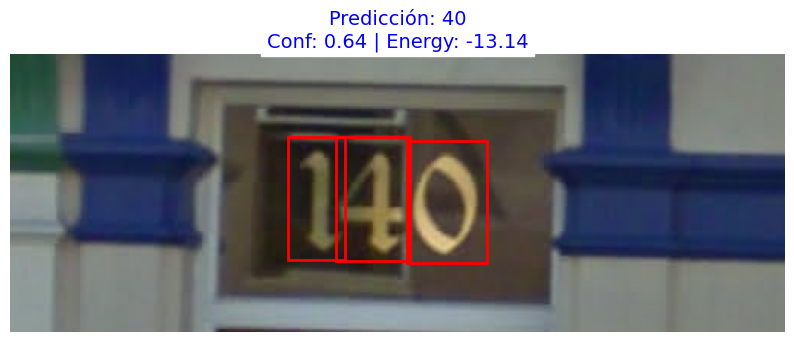


📸 Procesando: 7749.png


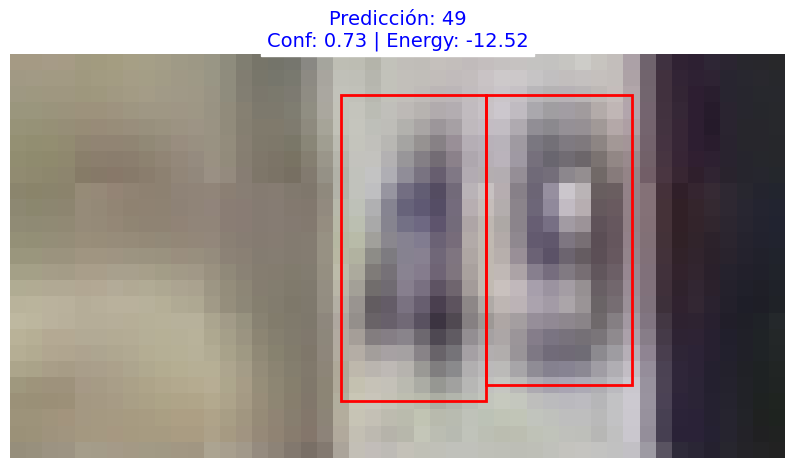


📸 Procesando: 11301.png


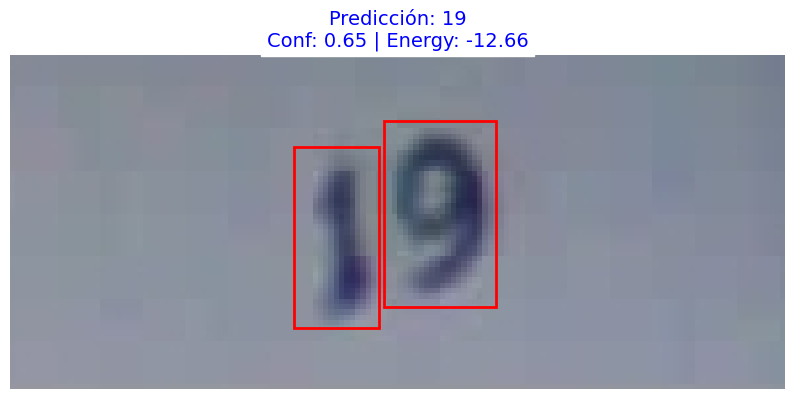

In [38]:
# ==============================================================================
# INFERENCIA VISUAL FINAL: YOLOv8 (640px) + CRNN A100 + PLOT
# ==============================================================================
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --------- CONFIGURACIÓN DE RUTAS ---------
RAIZ_SVHN = "/content/svhn_zip"
SALIDA_YOLO = "/content/svhn_yolo_dataset"

# 1. Ruta al CRNN (.keras)
RUTA_CRNN = os.path.join(RAIZ_SVHN, "crnn_a100_final.keras")

# 2. Ruta al YOLOv8 Small (Auto-búsqueda)
posibles_rutas_yolo = [
    os.path.join(SALIDA_YOLO, "runs", "svhn_yolov8s_640_pro", "weights", "best.pt"),
    os.path.join(SALIDA_YOLO, "runs", "svhn_yolov8s_640_ram", "weights", "best.pt"),
    os.path.join(SALIDA_YOLO, "runs", "detect", "svhn_yolov8s_640_pro", "weights", "best.pt")
]

RUTA_YOLOV8_PT = None
for p in posibles_rutas_yolo:
    if os.path.exists(p):
        RUTA_YOLOV8_PT = p
        break

# --------- PARÁMETROS ---------
CRNN_H, CRNN_W = 32, 128
ALFABETO = "0123456789"
INDICE_BLANCO = 10
NUM_CLASES = len(ALFABETO) + 1
YOLO_IMGSZ = 640

# --------- 1. RECONSTRUCCIÓN ARQUITECTURA CRNN ---------
def build_crnn():
    inputs = keras.Input(shape=(CRNN_H, CRNN_W, 3))
    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x); x = layers.MaxPool2D((2,2))(x)
    x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x); x = layers.MaxPool2D((2,2))(x)
    x = layers.SpatialDropout2D(0.1)(x)
    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x); x = layers.MaxPool2D((2,1))(x)
    x = layers.SpatialDropout2D(0.1)(x)
    x = layers.Conv2D(512, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(512, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x); x = layers.MaxPool2D((2,1))(x)
    x = layers.Conv2D(512, 2, padding="valid", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Lambda(lambda t: tf.squeeze(t, axis=1))(x)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.3))(x)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.3))(x)
    logits = layers.Dense(NUM_CLASES, name="logits", dtype='float32')(x)
    return keras.Model(inputs, logits)

# --------- 2. CARGA DE MODELOS ---------
print("⏳ Cargando modelos...")

if not os.path.exists(RUTA_CRNN):
    raise FileNotFoundError(f"❌ Falta CRNN: {RUTA_CRNN}")
if RUTA_YOLOV8_PT is None:
    raise FileNotFoundError(f"❌ Falta YOLO en {SALIDA_YOLO}/runs")

try:
    crnn = build_crnn()
    crnn.load_weights(RUTA_CRNN)
    print(f"✅ CRNN Listo")
except Exception as e:
    raise RuntimeError(f"❌ Error CRNN: {e}")

try:
    yolo = YOLO(RUTA_YOLOV8_PT)
    print(f"✅ YOLO Listo")
except Exception as e:
    raise RuntimeError(f"❌ Error YOLO: {e}")

# --------- 3. FUNCIONES AUXILIARES ---------
def colapsar_y_decodificar(logits):
    probs = tf.nn.softmax(logits, axis=-1)
    pred_ids = tf.argmax(probs, axis=-1).numpy()[0]
    out = []; prev = -1
    for ch in pred_ids:
        ch = int(ch)
        if ch != prev and ch != INDICE_BLANCO: out.append(ch)
        prev = ch
    return ''.join(ALFABETO[i] for i in out)

def metricas_ood(logits, T=1.0):
    logits = tf.cast(logits, tf.float32)
    probs = tf.nn.softmax(logits, axis=-1)
    msp = float(tf.reduce_mean(tf.reduce_max(probs, axis=2)).numpy())
    lse = tf.math.reduce_logsumexp(logits / T, axis=2)
    neg_energy = float(tf.reduce_mean(-T * lse).numpy())
    return neg_energy, msp

class Caja:
    def __init__(self, x1, y1, x2, y2, conf):
        self.xmin, self.ymin, self.xmax, self.ymax = int(x1), int(y1), int(x2), int(y2)
        self.conf = float(conf)

# --------- 4. PIPELINE DE INFERENCIA ---------
def pipeline_estricto(ruta_imagen, conf_yolo=0.5):
    if not os.path.exists(ruta_imagen):
        raise FileNotFoundError(f"Imagen no encontrada: {ruta_imagen}")

    # A. YOLO
    pil_img = Image.open(ruta_imagen).convert("RGB")
    np_img = np.array(pil_img)

    results = yolo.predict(np_img, imgsz=YOLO_IMGSZ, conf=conf_yolo, verbose=False)[0]

    cajas = []
    if results.boxes:
        for box in results.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = box.conf[0].cpu().numpy()
            cajas.append(Caja(x1, y1, x2, y2, conf))

    cajas.sort(key=lambda c: c.xmin)

    if not cajas:
        raise RuntimeError("⚠️ YOLO no encontró dígitos.")

    # B. RECORTE Y COSIDO
    recortes = []
    H_orig, W_orig = np_img.shape[:2]

    for c in cajas:
        x1, y1 = max(0, c.xmin), max(0, c.ymin)
        x2, y2 = min(W_orig, c.xmax), min(H_orig, c.ymax)
        crop = np_img[y1:y2, x1:x2]
        if crop.size == 0: continue

        new_w = max(1, int(crop.shape[1] * (CRNN_H / crop.shape[0])))
        crop_pil = Image.fromarray(crop).resize((new_w, CRNN_H), Image.BILINEAR)
        recortes.append(np.array(crop_pil))

    if not recortes: raise RuntimeError("⚠️ Error procesando recortes.")

    pad = 2
    total_w = sum(r.shape[1] for r in recortes) + (pad * (len(recortes)-1))
    lienzo = np.ones((CRNN_H, total_w, 3), dtype=np.uint8) * 128

    curr_x = 0
    for r in recortes:
        lienzo[:, curr_x:curr_x+r.shape[1]] = r
        curr_x += r.shape[1] + pad

    # C. CRNN PREP
    img_tf = tf.convert_to_tensor(lienzo)
    img_tf = tf.image.convert_image_dtype(img_tf, tf.float32)

    target_w = tf.shape(img_tf)[1]
    if target_w > CRNN_W: img_res = tf.image.resize(img_tf, (CRNN_H, CRNN_W))
    else: img_res = img_tf

    curr_w = tf.shape(img_res)[1]
    if curr_w < CRNN_W:
        pad_w = CRNN_W - curr_w
        img_input = tf.pad(img_res, [[0,0], [0,pad_w], [0,0]], constant_values=0.5)
    else:
        img_input = img_res

    img_input = (img_input - 0.5) / 0.5
    img_input = tf.expand_dims(img_input, 0)

    # D. INFERENCIA
    logits = crnn.predict(img_input, verbose=0)
    texto = colapsar_y_decodificar(logits)
    neg_e, msp = metricas_ood(logits)

    return {
        "texto": texto,
        "conf_yolo": np.mean([c.conf for c in cajas]),
        "neg_energy": neg_e,
        "cajas_coords": [(c.xmin, c.ymin, c.xmax, c.ymax) for c in cajas] # <--- ¡NUEVO!
    }

# --------- 5. VISUALIZACIÓN (¡ESTO ES LO QUE QUERÍAS!) ---------
def visualizar_resultado(img_path, resultado):
    img = Image.open(img_path)

    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    ax = plt.gca()

    # Dibujar Cajas
    for (x1, y1, x2, y2) in resultado['cajas_coords']:
        w, h = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    # Texto Predicho
    info = f"Predicción: {resultado['texto']}\nConf: {resultado['conf_yolo']:.2f} | Energy: {resultado['neg_energy']:.2f}"
    plt.title(info, fontsize=14, color='blue', backgroundcolor='white')
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    test_dir = os.path.join(RAIZ_SVHN, "test", "test")
    imgs_test = [f for f in os.listdir(test_dir) if f.endswith(".png")]

    if imgs_test:
        import random
        # Probamos 3 imágenes
        for _ in range(3):
            fn = random.choice(imgs_test)
            path = os.path.join(test_dir, fn)
            print(f"\n📸 Procesando: {fn}")
            try:
                # Inferencia
                res = pipeline_estricto(path, conf_yolo=0.3)
                # Visualización Gráfica
                visualizar_resultado(path, res)
            except Exception as e:
                print(f"⚠️ {e}")
    else:
        print("No hay imágenes para probar.")

📸 Procesando tu imagen: /content/shopping.png

🔢 LECTURA FINAL:  84716
📊 Confianza YOLO: 0.71
⚡ Energía (OOD):  -13.29



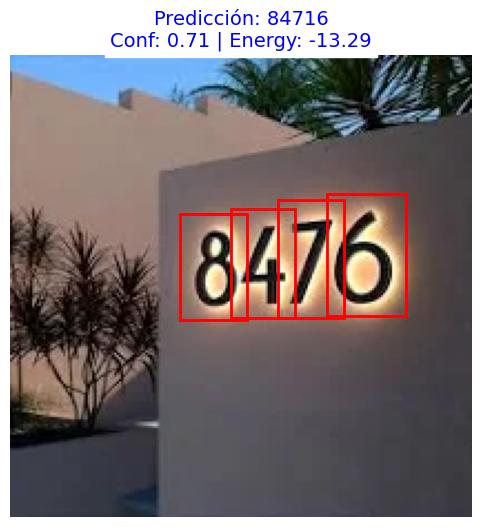

In [39]:
# ==========================================================
# 🧪 PRUEBA CON TU PROPIA IMAGEN (CUSTOM UPLOAD)
# ==========================================================

# 1. PEGA AQUÍ LA RUTA DE TU IMAGEN SUBIDA
# Ejemplo: "/content/mi_foto_del_celular.jpg"
RUTA_TU_IMAGEN = "/content/shopping.png"  # <--- CAMBIA ESTO

# ----------------------------------------------------------
import os

if os.path.exists(RUTA_TU_IMAGEN):
    print(f"📸 Procesando tu imagen: {RUTA_TU_IMAGEN}")
    try:
        # A. Ejecutar el pipeline (Detectar -> Recortar -> Leer)
        # Usamos conf=0.25 para ser más sensibles con fotos difíciles
        resultado = pipeline_estricto(RUTA_TU_IMAGEN, conf_yolo=0.25)

        # B. Mostrar resultados
        print("\n" + "="*40)
        print(f"🔢 LECTURA FINAL:  {resultado['texto']}")
        print(f"📊 Confianza YOLO: {resultado['conf_yolo']:.2f}")
        print(f"⚡ Energía (OOD):  {resultado['neg_energy']:.2f}")
        print("="*40 + "\n")

        # C. Dibujar la imagen con las cajas
        visualizar_resultado(RUTA_TU_IMAGEN, resultado)

    except Exception as e:
        print(f"❌ Error procesando la imagen: {e}")
        print("💡 Consejo: Asegúrate de que la imagen tenga números visibles y esté horizontal.")
else:
    print("❌ No encuentro el archivo. Revisa que la ruta sea correcta.")